Successfully loaded data from: C:/Users/joshu/OneDrive/Desktop/ApplesML/data/Detect-GD.xlsx
                 Sample Condition Age Source  11995.49  11991.63  11987.78  \
0  GD-ch-bruise1.5h-10a         B  1h     S1 -0.083126 -0.082581 -0.082173   
1  GD-ch-bruise1.5h-10b         B  1h     S1 -0.154684 -0.154762 -0.154668   
2  GD-ch-bruise1.5h-10c         S  1h     S1 -0.066006 -0.065688 -0.065200   
3  GD-ch-bruise1.5h-10d         S  1h     S1 -0.110366 -0.110041 -0.109542   
4  GD-ch-bruise1.5h-11a         B  1h     S1 -0.142115 -0.141852 -0.141603   

   11983.92  11980.06  11976.21  ...  4034.497   4030.64  4026.783  4022.926  \
0 -0.081704 -0.081251 -0.080829  ...  1.208914  1.216652  1.219303  1.207366   
1 -0.154153 -0.153504 -0.153067  ...  0.744595  0.745167  0.743545  0.744555   
2 -0.064603 -0.064006 -0.063497  ...  1.443587  1.456797  1.474139  1.478318   
3 -0.109117 -0.108661 -0.108094  ...  1.257423  1.262108  1.269531  1.262279   
4 -0.141129 -0.140701 -0.140477  ...  0

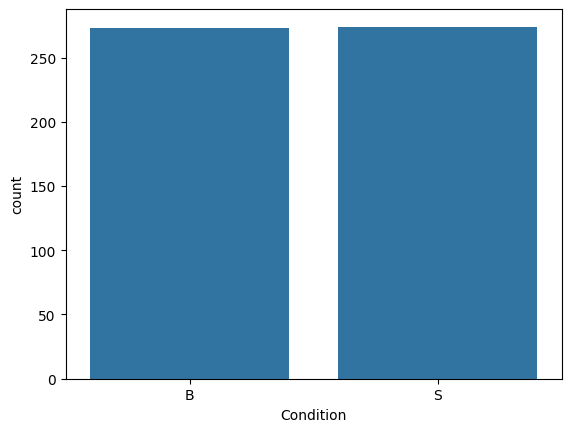

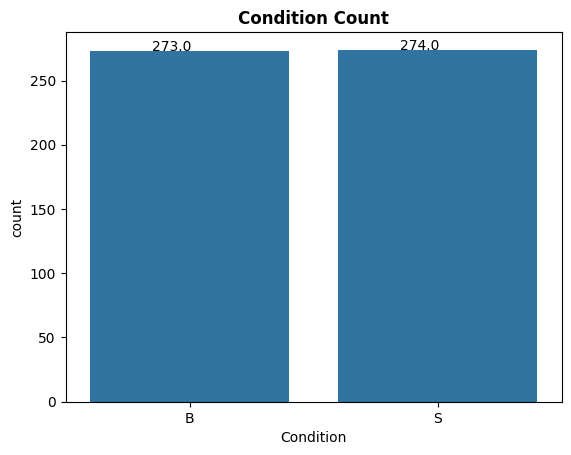

Best SVM Model: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Precision score for SVM model: 0.8462
Accuracy score for SVM model: 0.8788


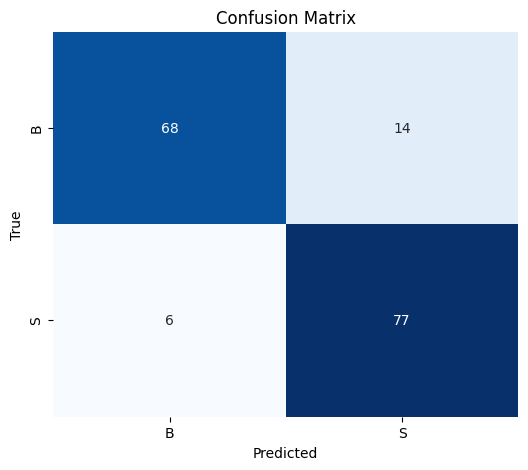

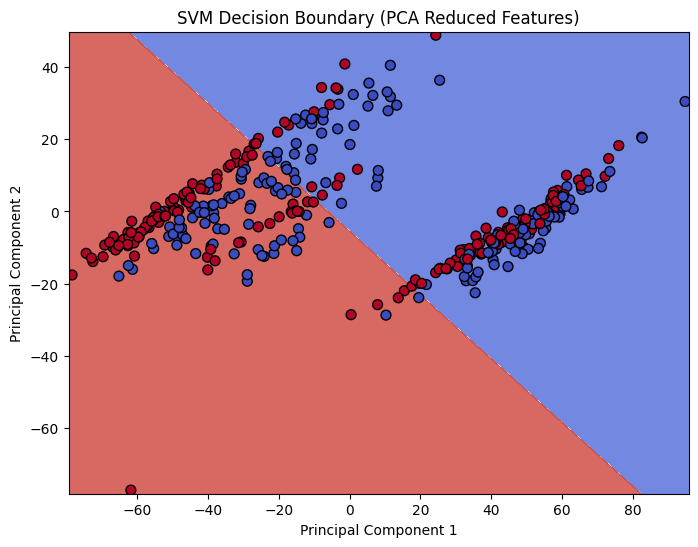

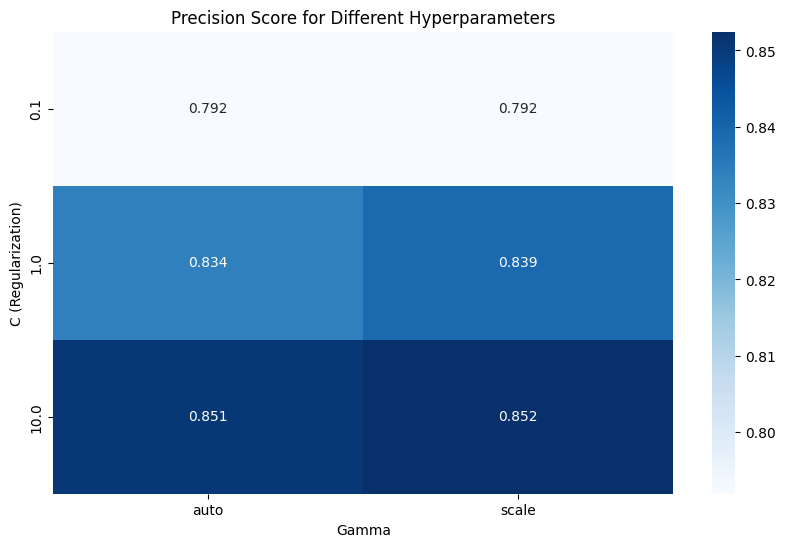

In [ ]:
# Import necessary libraries for SVM, metrics, and visualization
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA  

# Load Excel Data
file_path = 'C:/Users/joshu/OneDrive/Desktop/ApplesML/data/Detect-GD.xlsx'
df = pd.read_excel(file_path)
print(f"Successfully loaded data from: {file_path}")

# View first 5 rows
print(df.head())

# Shape of dataset
df_shape = df.shape
print(f"The shape of the infrared intensity data is {df_shape}")
print(f"Where {df_shape[0]} is the number of rows, and {df_shape[1]} is the number of columns.")

# Convert wavenumbers to wavelengths
wavenumbers = np.float64(df.columns[4:])
wavelengths = (1 / wavenumbers) * 1e7
print(f"\nExample: wave number {wavenumbers[0]} in inverse centimeters converts to a wavelength of {wavelengths[0]} nm\n")
df.columns.values[4:] = np.round(wavelengths, 3)
print(df.head())

# Condition Count Visualization
ax = sns.countplot(x="Condition", data=df)
plt.show()

# Normalize Condition column (make uppercase)
df['Condition'] = df['Condition'].str.upper()
ax = sns.countplot(x="Condition", data=df)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}', (p.get_x() + 0.25, p.get_height() + 0.01))

plt.title("Condition Count", fontsize=12, fontweight='bold')
plt.show()

# Features (X) and Labels (Y)
X = df.iloc[:, 4:]
Y = df['Condition']

# Scaling Inputs
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

# Convert target labels to binary
Y = Y.map({'S': 1, 'B': 0})

# Use train_test_split directly to split the data
from sklearn.model_selection import train_test_split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.3, random_state=3, stratify=Y)

# Hyperparameters for SVM (Search space for tuning)
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto'],  
}

# SVM with GridSearchCV for hyperparameter tuning
grid_search_svm = GridSearchCV(SVC(), param_grid_svm, cv=3, scoring='precision', n_jobs=-1)
grid_search_svm.fit(Xtrain, Ytrain)

# Best model from GridSearchCV
best_svm_model = grid_search_svm.best_estimator_

# Predictions and Evaluation
y_pred_svm = best_svm_model.predict(Xtest)
precision = precision_score(Ytest, y_pred_svm)

print(f"Best SVM Model: {grid_search_svm.best_params_}")
print(f"Precision score for SVM model: {precision:.4f}")

accuracy = accuracy_score(Ytest, y_pred_svm)
print(f"Accuracy score for SVM model: {accuracy:.4f}")


# Visualization 1: Confusion Matrix
conf_matrix = confusion_matrix(Ytest, y_pred_svm)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["B", "S"], yticklabels=["B", "S"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# Visualization 2: Decision Boundary (Only works well for 2D or reduced dimensionality)
# Use PCA for dimensionality reduction to 2D
pca = PCA(n_components=2)
Xtrain_pca = pca.fit_transform(Xtrain)
Xtest_pca = pca.transform(Xtest)


# Train the SVM model on the 2D PCA features
best_svm_model.fit(Xtrain_pca, Ytrain)


# Create a mesh grid for decision boundary plot
x_min, x_max = Xtrain_pca[:, 0].min() - 1, Xtrain_pca[:, 0].max() + 1
y_min, y_max = Xtrain_pca[:, 1].min() - 1, Xtrain_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))


# Get decision boundary predictions
Z = best_svm_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.8, cmap="coolwarm")
plt.scatter(Xtrain_pca[:, 0], Xtrain_pca[:, 1], c=Ytrain, marker='o', edgecolors='k', cmap="coolwarm", s=50)
plt.title("SVM Decision Boundary (PCA Reduced Features)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

# Visualization 3: Precision Score vs. Hyperparameters
# Plotting Precision vs. SVM Hyperparameters
param_results = pd.DataFrame(grid_search_svm.cv_results_)
param_results = param_results[['param_C', 'param_kernel', 'param_gamma', 'mean_test_score']]

plt.figure(figsize=(10, 6))
sns.heatmap(param_results.pivot_table(index='param_C', columns='param_gamma', values='mean_test_score'), annot=True, cmap="Blues", fmt=".3f")
plt.title("Precision Score for Different Hyperparameters")
plt.xlabel("Gamma")
plt.ylabel("C (Regularization)")
plt.show()
